# Several projections onto modified simplices

???

TODO u obrazku pro p a q je spatne x-ova osa pro q

TODO jeste dopsat

This text is a complementary material to our paper ???, where we consider three projections onto modified simplices coming from the fields of distributionally robust optimization (DRO) and accuracy at the top (AATP).



##  Preliminaries

This notebook and the codes can be accessed without any installations. To change the codes, it is necessary to install [Julia](https://julialang.org/downloads/) and the [ProjectionExamples](https://github.com/VaclavMacha/ProjectionsExamples) package. The latter can be done using the following commands

```julia
julia> using Pkg
julia> Pkg.add(PackageSpec(url = "https://github.com/VaclavMacha/ProjectionsExamples.git", rev = "master"))
```
After doing so, we load the packages and set the seed and tolerances by running

In [1]:
using ProjectionsExamples
using ProjectionsExamples.Projections, ProjectionsExamples.Distributions, ProjectionsExamples.Random

Random.seed!(666);
atol = 1e-8;

┌ Info: Recompiling stale cache file C:\Users\sadda\.julia\compiled\v1.1\ProjectionsExamples\GunRa.ji for ProjectionsExamples [6209a1fa-61a1-11e9-143d-bd6d021d63ce]
└ @ Base loading.jl:1184


## 1. Problem (DRO)

Problem (DRO) stems from the distributinally robust optimization and reads

$$
\begin{aligned}
\underset{\mathbf{p}}{\mathrm{minimize}} \ & \mathbf{c}^\top \mathbf{p} \\
\mathrm{subject\ to}\ &\sum_{i=1}^np_i=1,\\
&0\le p_i,\quad\forall i=1,\dots,n,\\
&\| \mathbf{p} - \mathbf{p}^0\|_{k}  \le\varepsilon.
\end{aligned}
$$
For the detailed problem derivation, please refer to our paper.

### 1.1. Solution properties

Since the problem does not depend on the order of the components of $\mathbf{p}$, without loss of generality we assume that $\mathbf{c}$ is sorted. First, we generate random data and then compute the optimal solution for problem (DRO).

In [2]:
n  = 20;
p0 = ones(n)/n;
c  = sort(rand(Normal(0,1), n));
ε  = 0.05;

p_l1   = Projections.minimize_linear_on_simplex_l1(p0, c, ε);
p_l2   = Projections.minimize_linear_on_simplex_l2(p0, c, ε);
p_lInf = Projections.minimize_linear_on_simplex_lInf(p0, c, ε);

To check whether our solution is correct, we compare it with the solution given by the [ECOS](https://github.com/JuliaOpt/ECOS.jl) solver. To keep the presentation simple, we compare results only for the $l_{1}$ norm.

In [3]:
p_l1_solver = Projections.minimize_linear_on_simplex_exact(p0, c, ε, 1);

ProjectionsExamples.l1_comparison(p_l1, p_l1_solver, c, p0, ε)

‖p_l1_solver - p_l1‖  = 2.643e-12


Now we plot the obtained solutions for all three norms. Since $\mathbf{p}$ is a probability distribution, an increase in one component has to lead to a decrease in another. Since the objective is linear, the solution will have large values of $p_i$ whenever $c_i$ is small and small values of $p_i$ whenever $c_i$ is large. This is shown in the next graph. Recall that $\mathbf{p}^{0}$ follows the uniform distribution and that $\mathbf{c}$ is sorted. It is interesting to observe the values of $\mathbf p$ for different norms. While the $l_1$ and $l_\infty$ norms lead to significant deviations from $\mathbf p^0$, the $l_2$ norm leads to a more balanced solution. This suggests to use the $l_2$ distance in the distributionally robust optimization.

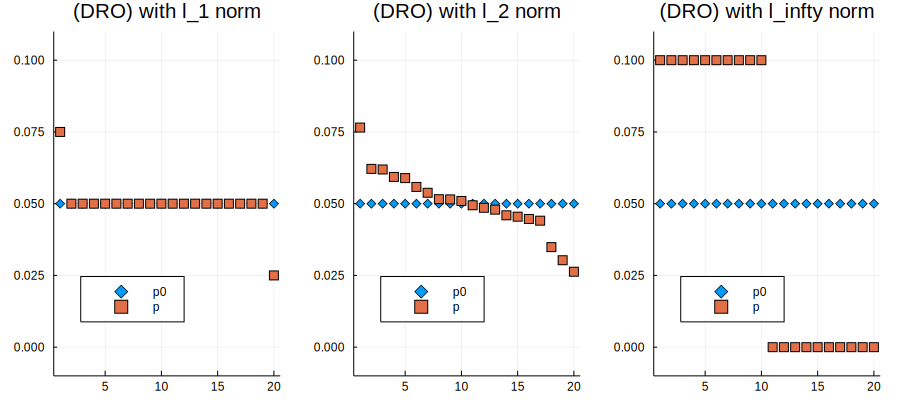

In [4]:
ProjectionsExamples.l12Inf_plots(p_l1, p_l2, p_lInf, p0, n)

### 1.2. Time comparison

We provide the time complexity of the presented algorithms. Denoting $n$ to be the length of $\mathbf{p}^{0}$, we consider $n \in [10^{2},10^{5}]$. For each $n$ we randomly generate data, solve (DRO) ten times and average the execution times. Since the algorithm for the $l_{2}$ norm uses a root finding method, we show three different methods.  The `Bisection` and `Secant` methods are general methods implemented in [Roots](https://github.com/JuliaMath/Roots.jl) package, the `Newton` method is a simple implementation of the [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method.

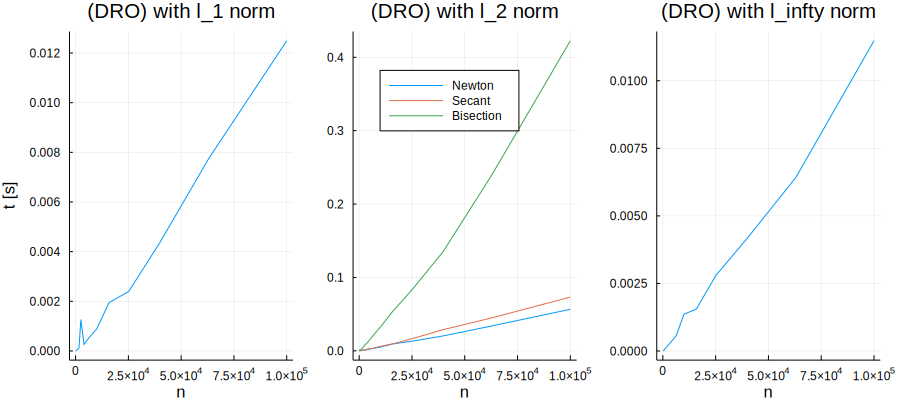

In [4]:
l = 2:0.2:5;
n = ceil.(Int64, 10 .^l);

ProjectionsExamples.l12Inf_timecomparison(n, maxreps = 10)

In the figure above we see (almost) linear dependence of time on the data size $n$. For the $l_{2}$ norm we provide the comparison of our method and the algorithm from [[Philpott 2018]](https://link.springer.com/article/10.1007/s10287-018-0314-0). The computational complexity of `Phillpot` is quadratic and the running time is much higher than ours. 

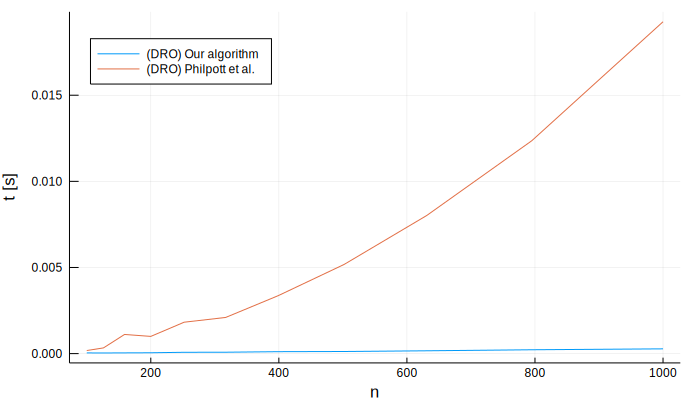

In [5]:
l = 2:0.1:3;
n = ceil.(Int64, 10 .^l);

ProjectionsExamples.philpott_timecomparison(n, maxreps = 10)

## 2. Problems (AATP1) and (AATP2) 

The next two problems stem from the accuracy at the top which is a binary classification problem maximizing the accuracy for the few top samples. The (AATP1) problem reads

$$
\begin{aligned}
\underset{\mathbf{p},\mathbf{q}, r}{\mathrm{minimize}}\ & \frac{1}{2} \|\mathbf{p} - \mathbf{p}^0\|^2 + \frac{1}{2} \|\mathbf{q} - \mathbf{q}^0\|^2 + \frac{1}{2}(r-r^0)^2  \\
\mathrm{subject\ to}\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le C_2r,\quad\forall j=1,\dots,m,
\end{aligned}
$$
while the (AATP2) problem reads

$$
\begin{aligned}
\underset{\mathbf{p},\mathbf{q}}{\mathrm{minimize}}\ & \frac{1}{2} \|\mathbf{p} - \mathbf{p}^0\|^2 + \frac{1}{2} \|\mathbf{q} - \mathbf{q}^0\|^2 \\
\operatorname{subject\ to}\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le \frac{1}{C_2}\sum_{i=1}^n p_i,\quad\forall j=1,\dots,m.
\end{aligned}
$$
For the detailed problem derivation, please refer to our paper again.

### 2.1. Solution properties

Similarly to (DRO), first we randomly generate sorted data and then compute the projections by solving (AATP1) and (AATP2).

In [6]:
n    = 20;
m    = 30;
p0   = sort(rand(Normal(0,1), n));
q0   = sort(rand(Normal(0,1), m));
r0   = rand(Uniform(0,1));
C1   = 0.7;
C2_1 = 0.9;
C2_2 = 9;

p1, q1, r1 = Projections.simplex_mod1(p0, q0, r0, C1, C2_1; atol = atol);
p2, q2     = Projections.simplex_mod2(p0, q0, C1, C2_2; atol = atol);

To check if our solution is correct, we compare it with the solution given by the [ECOS](https://github.com/JuliaOpt/ECOS.jl)  solver.

In [7]:
p1_solver, q1_solver, r1_solver = Projections.simplex_mod1_exact(p0, q0, r0, C1, C2_1);
p2_solver, q2_solver            = Projections.simplex_mod2_exact(p0, q0, C1, C2_2);

ProjectionsExamples.mod1_comparison(p1, p1_solver, q1, q1_solver, r1, r1_solver, p0, q0, r0, C1, C2_1)
ProjectionsExamples.mod2_comparison(p2, p2_solver, q2, q2_solver, p0, q0, C1, C2_2)

‖p_solver - p‖ = 1.801e-6
‖q_solver - q‖ = 1.771e-6
‖r_solver - r‖ = 1.231e-6

‖p_solver - p‖ = 6.93e-6
‖q_solver - q‖ = 1.395e-5


Now we plot the optimal solutions for (AATP1) and (AATP2). Since both problems are similar, the solutions are also similar. This holds true especially for $\mathbf p$ where the upper bound is the same. The optimal $\mathbf q$ differs as the upper bounds differ as well.

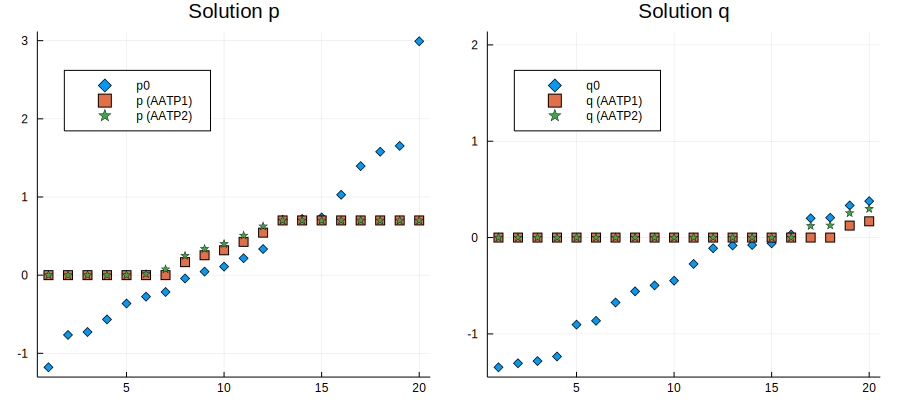

In [9]:
ProjectionsExamples.mod12_plots(p1, q1, p2, q2, p0, q0, n, m)

### 2.2. Time comparison

We provide the time complexity of the presented algorithms. We denote the number of points by $N$ and set $n=0.3N$ to be the length of $\mathbf p^0$ and $m = 0.7N$ to be the length of $\mathbf q^0$. Then for each $N \in [10^{2},10^{5}]$ we randomly generate data, solve (AATP1) and (AATP2) ten times and average the execution times. Since the algorithms use a root finding method, we show results for the `Bisection` and `Secant` methods from the [Roots](https://github.com/JuliaMath/Roots.jl) package.

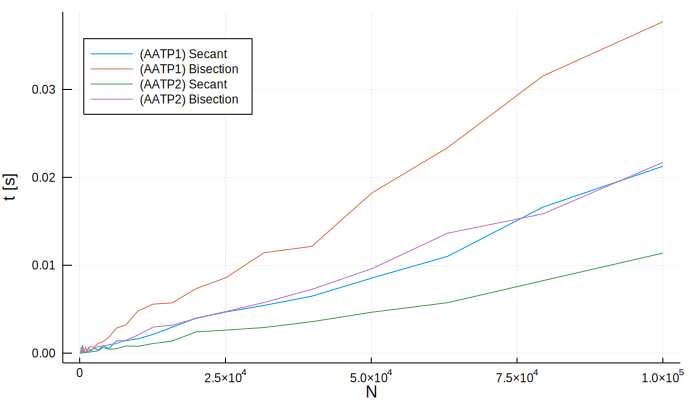

In [10]:
l = 2:0.1:5
N = @. ceil(Int64, 10^l);

ProjectionsExamples.mod12_timecomparison(N; maxreps = 10)

In the figure above we see the (almost) linear dependence of time on the data size $N$. Moreover, `Secant` is faster than `Bisection`. However, `Bisection` has a guaranteed convergence.